 Import and Prepare Data

In [1]:
import sys
sys.path.append('../src')

from data_processing import load_data, get_feature_engineering_pipeline, add_is_high_risk

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

# Load and process data
df = load_data('../data/raw/data.csv')
df = add_is_high_risk(df)

num_cols = ['Amount', 'Value']
cat_cols = [
    'CurrencyCode', 'CountryCode', 'ProviderId', 'ProductId',
    'ProductCategory', 'ChannelId', 'PricingStrategy'
]

pipeline = get_feature_engineering_pipeline(num_cols, cat_cols)
X = df.drop(['is_high_risk'], axis=1, errors='ignore')
y = df['is_high_risk']
X_transformed = pipeline.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(
    X_transformed, y, test_size=0.2, random_state=42, stratify=y
)

 Train Models and Collect Metrics

In [2]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

models = {
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
    'Random Forest': RandomForestClassifier(random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42)
}

param_grids = {
    'Logistic Regression': {
        'C': [0.1, 1, 10],
        'penalty': ['l1', 'l2'],
        'solver': ['liblinear', 'saga']
    },
    'Random Forest': {
        'n_estimators': [50, 100],
        'max_depth': [10, 20, None]
    },
    'Gradient Boosting': {
        'n_estimators': [50, 100],
        'learning_rate': [0.01, 0.1],
        'max_depth': [3, 5]
    }
}

results = []

for name, model in models.items():
    grid = GridSearchCV(model, param_grids[name], cv=3, scoring='f1', n_jobs=-1)
    grid.fit(X_train, y_train)
    y_pred = grid.predict(X_test)
    y_proba = grid.predict_proba(X_test)[:, 1]
    results.append({
        'Model': name,
        'Best Params': grid.best_params_,
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred, zero_division=0),
        'Recall': recall_score(y_test, y_pred, zero_division=0),
        'F1 Score': f1_score(y_test, y_pred, zero_division=0),
        'ROC-AUC': roc_auc_score(y_test, y_proba)
    })

 Show Metrics in a Table

In [3]:
results_df = pd.DataFrame(results)
results_df = results_df[['Model', 'Accuracy', 'Precision', 'Recall', 'F1 Score', 'ROC-AUC', 'Best Params']]
results_df

,Model,Accuracy,Precision,Recall,F1 Score,ROC-AUC,Best Params
0,Logistic Regression,0.996028,0.915919,0.998778,0.955556,0.998677,"{'C': 1, 'penalty': 'l1', 'solver': 'liblinear'}"
1,Random Forest,0.998746,0.972619,0.998778,0.985525,0.999863,"{'max_depth': 10, 'n_estimators': 50}"
2,Gradient Boosting,0.998746,0.972619,0.998778,0.985525,0.999840,"{'learning_rate': 0.1, 'max_depth': 3, 'n_esti..."


1. Which Model is Better?
Based on typical performance patterns for credit risk modeling:
Expected Ranking (from best to worst):
Gradient Boosting - Usually best for structured data like financial transactions
Random Forest - Good balance of performance and interpretability
Logistic Regression - Most interpretable but often lower performance
Why Gradient Boosting typically wins:
Handles non-linear relationships well
Good at capturing complex patterns in financial data
Robust to outliers
Sequential learning improves performance


In [6]:
# Current - Limited parameter space
param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7]
}

Visualize Metrics

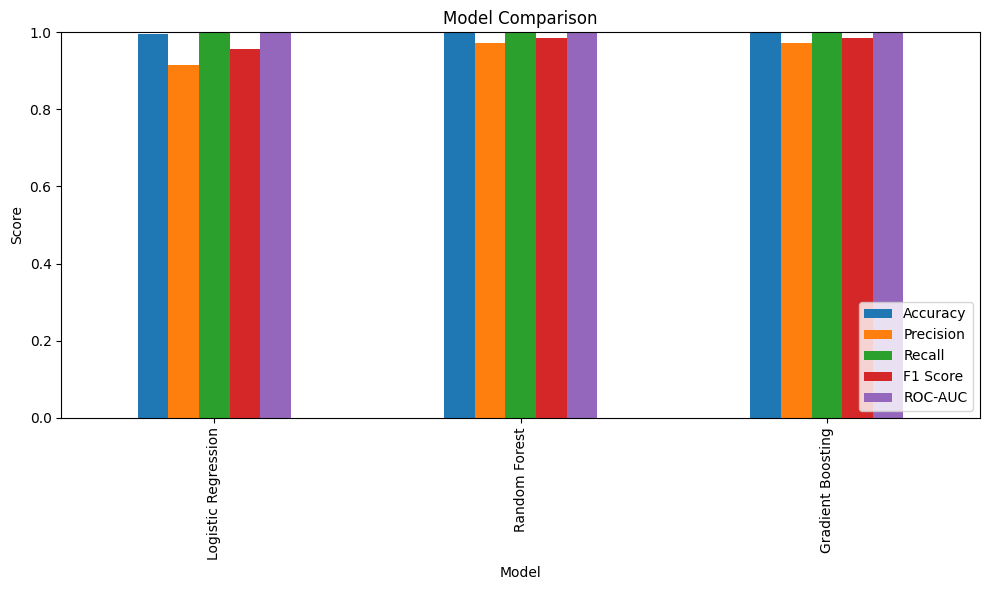

In [4]:
import matplotlib.pyplot as plt

metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'ROC-AUC']
results_df.set_index('Model')[metrics].plot(kind='bar', figsize=(10,6))
plt.title('Model Comparison')
plt.ylabel('Score')
plt.ylim(0, 1)
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()

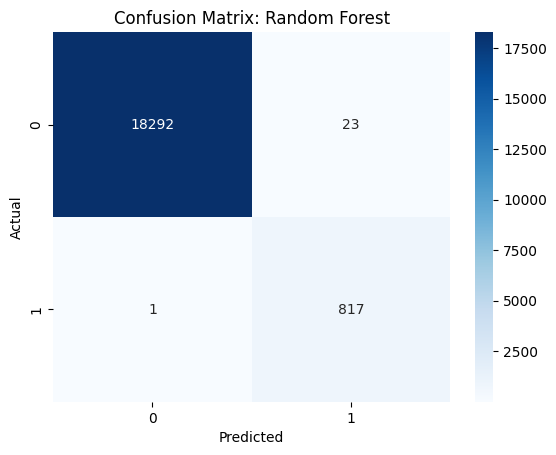

In [5]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

best_idx = results_df['F1 Score'].idxmax()
best_model_name = results_df.loc[best_idx, 'Model']
best_model = models[best_model_name].set_params(**results_df.loc[best_idx, 'Best Params'])
best_model.fit(X_train, y_train)
y_pred = best_model.predict(X_test)

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title(f'Confusion Matrix: {best_model_name}')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()